In [1]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize

In [2]:
import os
import sys
import random
import math
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class LoculesConfig(Config):
    NAME = "locules"
    BACKBONE = "resnet50"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2 + 1
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0001

config = LoculesConfig()
config.display()
    


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        35
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

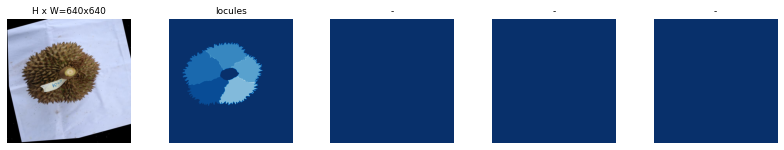

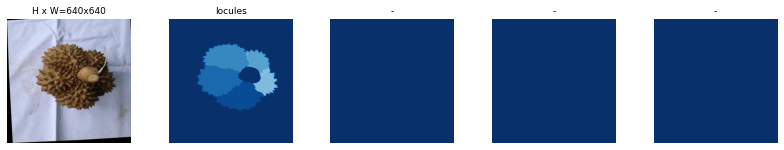

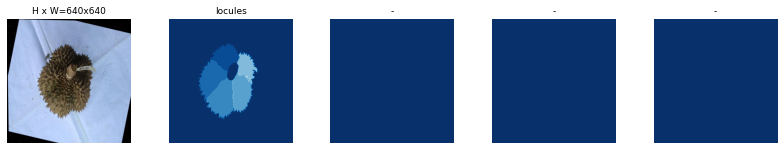

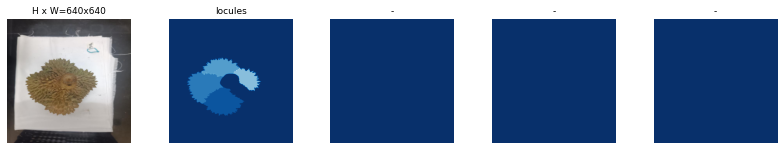

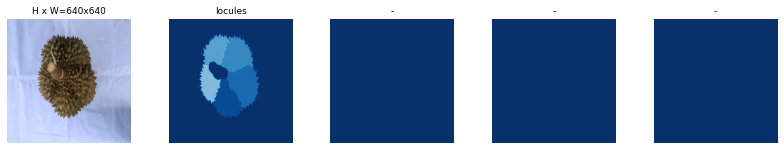

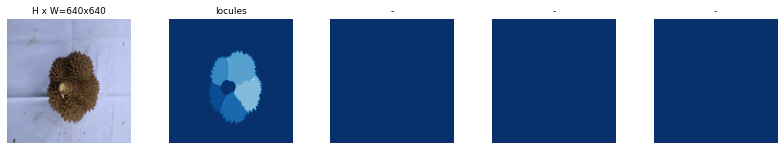

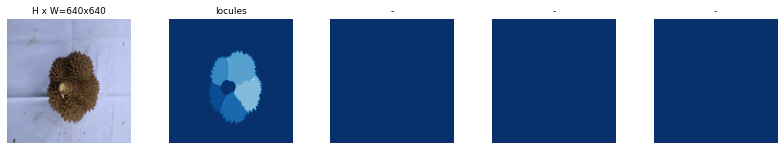

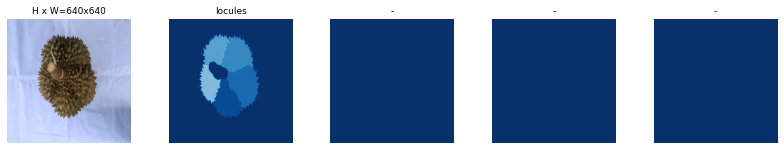

In [4]:
import numpy as np
from utils.custom_dataset import DurianLoculeDataset

dataset_train = DurianLoculeDataset()
dataset_train.load_data('./dataset/dataset/locule-4/train/_annotations.coco.json', './dataset/dataset/locule-4/train/')
dataset_train.prepare()

dataset_val = DurianLoculeDataset()
dataset_val.load_data('./dataset/dataset/locule-4/valid/_annotations.coco.json', './dataset/dataset/locule-4/valid/')
dataset_val.prepare()

dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    
dataset = dataset_val
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [5]:
import os
ROOT_DIR = os.path.abspath("./")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_MODEL_PATH)
print(MODEL_DIR)

/app/mask_rcnn_coco.h5
/app/logs


In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Train from coco checkpoint
model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

Test/visualizing the model

In [21]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = f"{ROOT_DIR}/dataset/dataset/locule-4"
print(CUSTOM_DIR)
dataset_test = DurianLoculeDataset()
dataset_test.load_data('./dataset/dataset/locule-4/train/_annotations.coco.json', './dataset/dataset/locule-4/train/')
dataset_test.prepare()


/app/dataset/dataset/locule-4


In [22]:
test_config = LoculesConfig()
# model = modellib.MaskRCNN(mode="inference", config=config, model_dir="./logs/locules20241028T2112/mask_rcnn_locules_0003.h5")
test_model = modellib.MaskRCNN(mode="inference", config=test_config, model_dir=MODEL_DIR)

WEIGHTS_PATH = "./logs/locules20241028T2112/mask_rcnn_locules_0003.h5"

In [23]:
print("Loading weights ", WEIGHTS_PATH)
test_model.load_weights(WEIGHTS_PATH, by_name=True)

Loading weights  ./logs/locules20241028T2112/mask_rcnn_locules_0003.h5
Re-starting from epoch 3


In [24]:
#RUN DETECTION
image_id = random.choice(dataset_test.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset_test, test_config, image_id)
info = dataset_test.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = test_model.detect([image], verbose=1)

image id is : 71
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -120.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


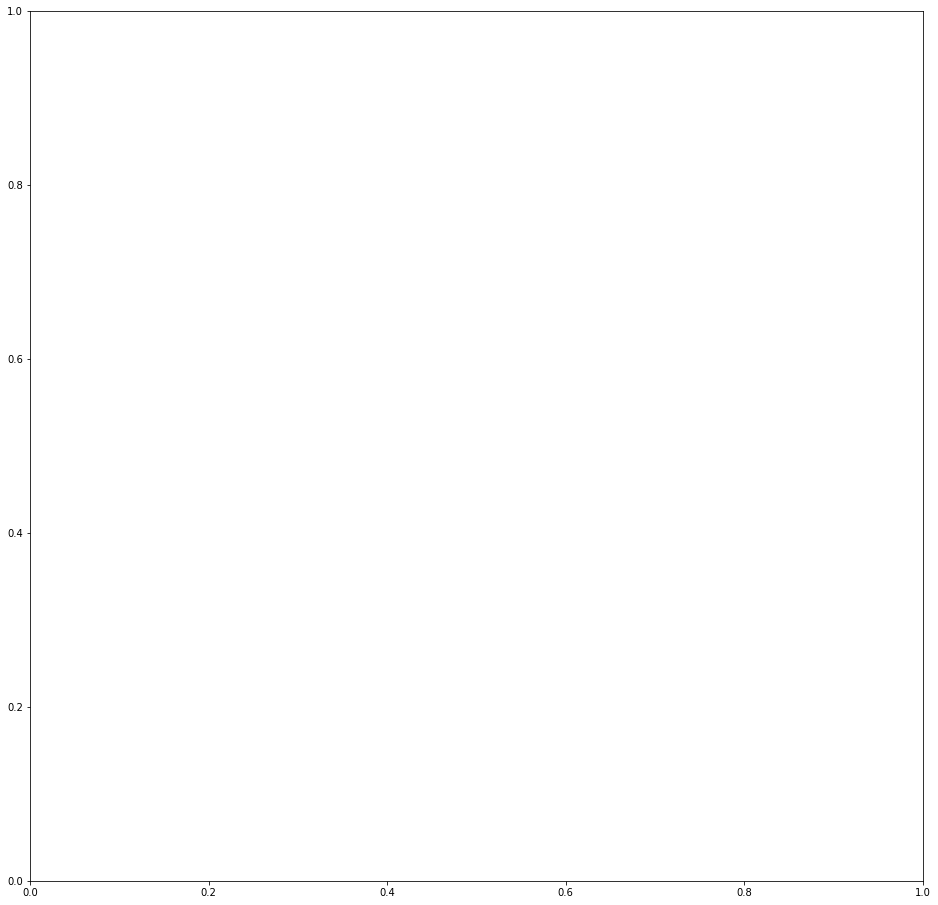

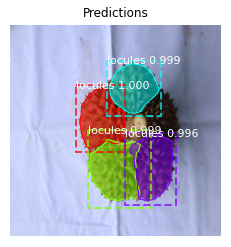

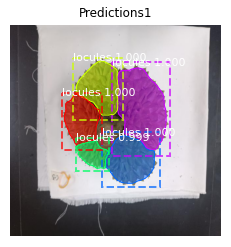

In [25]:
import matplotlib.image as mpimg
# # Display results
# x = get_ax(1)
# r = results[0]
# ax = plt.gca()
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_test.class_names, r['scores'], figAx=ax, title="Predictions")
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# IMAGE="./dataset/dataset/locule-4/train/27-09-2023_DSLR_CLASS2-MIDRIPE_5D-13_05_03_JPG.rf.71de4574f5397e2cc69c038e51cc0774.jpg"

# # This is for predicting images which are not present in dataset
# path_to_new_image = IMAGE # Change this
# image1 = mpimg.imread(path_to_new_image)

# # Run object detection
# print(len([image1]))
# results1 = model.detect([image1], verbose=1)

# # Display results
# ax = get_ax(1)
# r1 = results1[0]
# visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
# dataset_test.class_names, r1['scores'], figAx=ax, title="Predictions1")

# Display results
x = get_ax(1)
r = results[0]

# Create figure and axis for passing as figAx
fig, ax = plt.subplots(1)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_test.class_names, r['scores'], figAx=(fig, ax), title="Predictions")

# Logging
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

IMAGE = "./dataset/dataset/locule-4/test/IMG_20240123_084847_jpg.rf.5fbf49557f5941f461eb188da4dae510.jpg"

# This is for predicting images not present in the dataset
path_to_new_image = IMAGE  # Change this if needed
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = test_model.detect([image1], verbose=1)

# Display results for the new image
fig, ax = plt.subplots(1)  # Create new figure and axis
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            dataset_test.class_names, r1['scores'], figAx=(fig, ax), title="Predictions1")


## Performance Metrics:

- mAP@0.5
- mAP@0.75
- mAP@0.5-0.95
- mIoU

In [6]:
import os
import re

mask_rcnn_pattern = r'^mask_rcnn.*\.h5$'
home_dir = os.getcwd()

# Get the first item in the MODEL_DIR
latest_log_dir = os.listdir(MODEL_DIR)[1]  # Change to 0
directory_content = os.listdir(os.path.join(MODEL_DIR, latest_log_dir))

# Search for files matching the mask_rcnn pattern
matching_files = [f for f in directory_content if re.search(mask_rcnn_pattern, f)]

# Check if there are any matching files
if matching_files:
    latest_weight = matching_files[-1]
    print("Latest matching file:", latest_weight)

    # Construct the full path to the latest weight file
    latest_weight_dir = os.path.join(MODEL_DIR, latest_log_dir, latest_weight)
    print("Latest weight file path:", latest_weight_dir)
else:
    print("No matching files found.")


Latest matching file: mask_rcnn_locules_0003.h5
Latest weight file path: /app/logs/locules20241028T2112/mask_rcnn_locules_0003.h5


In [7]:
from mrcnn.utils import compute_ap, compute_ap_range

from utils.custom_dataset import DurianLoculeDataset

TEST_DATASET_JSON = "./dataset/dataset/locule-4/test/_annotations.coco.json"
TEST_DATASET_DIR = "./dataset/dataset/locule-4/test/"
TRAINED_MODEL_WEIGHTS_PATH = latest_weight_dir

dataset_test = DurianLoculeDataset()
dataset_test.load_data(TEST_DATASET_JSON, TEST_DATASET_DIR)
dataset_test.prepare()

test_config = LoculesConfig()
test_model = modellib.MaskRCNN(mode="inference", config=test_config, model_dir=MODEL_DIR)
test_model.load_weights(TRAINED_MODEL_WEIGHTS_PATH, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Re-starting from epoch 3


In [8]:
import matplotlib.pyplot as plt

In [14]:
from mrcnn import utils

def compute_batch_ap(image_ids, iou_threshold=0.50):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, test_config, image_id)
        # Run object detection
        results = test_model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                            r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=iou_threshold)
        APs.append(AP)
    return APs

image_ids = dataset_test.image_ids
APs = compute_batch_ap(image_ids, iou_threshold=0.50)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  1.0


In [29]:
def compute_batch_ranged_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, test_config, image_id)
        
        # Run object detection
        results = test_model.detect([image], verbose=0)
        r = results[0]
        
        # Compute AP (assuming compute_ap_range only returns AP as a single float)
        AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'], verbose=0
        )
        
        # Append AP score for this image to the list
        APs.append(AP)
    
    return APs

# Get list of image IDs and compute ranged APs
image_ids = dataset_test.image_ids
APs = compute_batch_ranged_ap(image_ids)

# Print mean AP
print("mAP: ", np.mean(APs))


mAP:  0.846266667937239


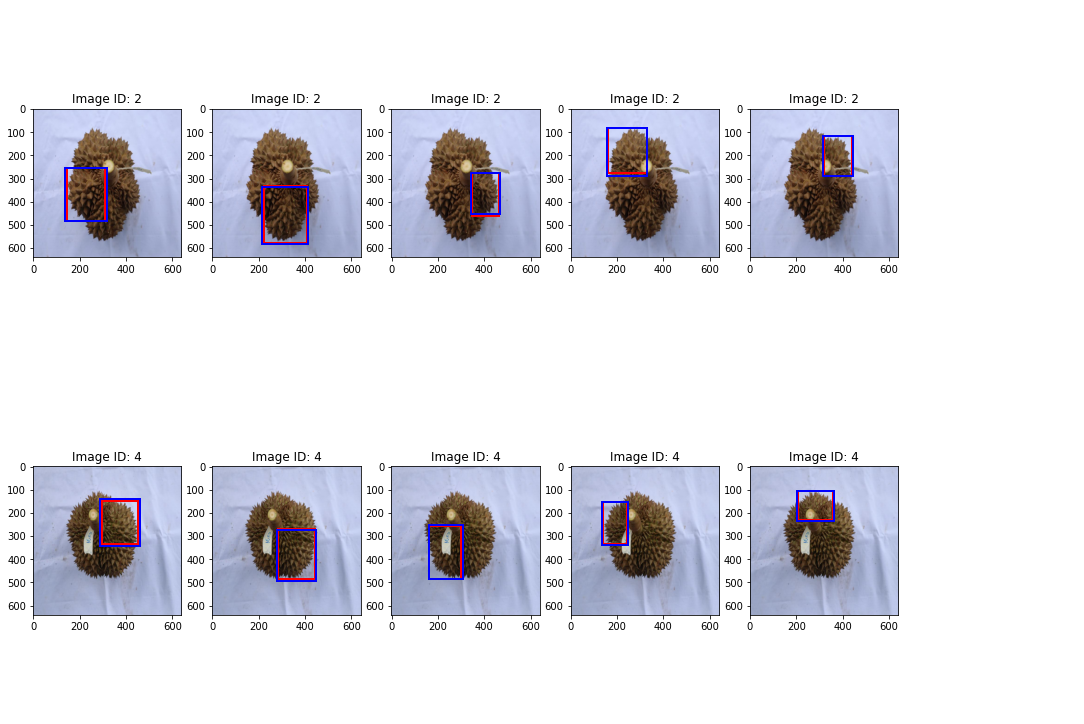

Mean IoU:  0.9078176347498905


In [30]:
from mrcnn.utils import get_iou

def draw_bounding_boxes(ax, image, gt_box, best_pred_box, image_id):
    """
    Draw ground truth and predicted bounding boxes on the given axes.
    
    Args:
        ax: The axes to draw on.
        image: The image to display.
        gt_box: The ground truth bounding box in the format [y0, x1, y2, x2].
        best_pred_box: The best predicted bounding box in the format [y0, x1, y2, x2].
        image_id: The ID of the image.
    """
    ax.imshow(image)
    
    # Draw ground truth box
    gt_y0, gt_x1, gt_y2, gt_x2 = gt_box
    ax.add_patch(plt.Rectangle((gt_x1, gt_y0), gt_x2 - gt_x1, gt_y2 - gt_y0,
                                fill=False, edgecolor='red', lw=2, label='Ground Truth'))
    
    # Draw predicted box if it exists
    if best_pred_box is not None:
        pred_y0, pred_x1, pred_y2, pred_x2 = best_pred_box
        ax.add_patch(plt.Rectangle((pred_x1, pred_y0), pred_x2 - pred_x1, pred_y2 - pred_y0,
                                    fill=False, edgecolor='blue', lw=2, label='Prediction'))

    ax.set_title(f"Image ID: {image_id}")

def display_bounding_boxes(image_data):
    """
    Display images with their ground truth and predicted bounding boxes in a grid layout.

    Args:
        image_data: A dictionary where keys are image IDs and values are lists of tuples 
                    containing (image, gt_box, best_pred_box).
    """
    max_columns = 6  # Maximum number of columns
    rows = len(image_data)  # Number of unique image IDs
    grid_size = (rows, max_columns)  # Grid size (rows, columns)
    
    fig, axes = plt.subplots(*grid_size, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten the grid for easy iteration

    for idx, (image_id, bounding_boxes) in enumerate(image_data.items()):
        for col in range(max_columns):
            ax = axes[idx * max_columns + col]
            if col < len(bounding_boxes):
                image, gt_box, best_pred_box = bounding_boxes[col]
                draw_bounding_boxes(ax, image, gt_box, best_pred_box, image_id)
            else:
                ax.axis('off')  # Hide axes if no image available

    plt.tight_layout(pad=0.5, h_pad=0.5)  # Adjust layout
    plt.show()

def compute_batch_iou(image_ids):
    IOUs = []
    image_data = {}
    selected_image_ids = np.random.choice(image_ids, 2)  # Select 2 random image IDs

    for image_id in image_ids:
        # Load image
        image, _, _, gt_bbox, _ = modellib.load_image_gt(dataset_test, test_config, image_id)
        
        # Run object detection
        results = test_model.detect([image], verbose=0)
        r = results[-1]
        
        # Prepare to store bounding boxes for this image_id
        bounding_boxes = []

        # Loop over each ground truth bounding box
        for gt_box in gt_bbox:
            gt_y0, gt_x1, gt_y2, gt_x2 = gt_box
            best_iou = -1
            best_pred_box = None
            
            # Find the predicted box with the highest IoU for this ground truth box
            for pred_box in r['rois']:
                pred_y0, pred_x1, pred_y2, pred_x2 = pred_box
                iou = get_iou([gt_x1, gt_y0, gt_x2, gt_y2], [pred_x1, pred_y0, pred_x2, pred_y2])
                
                if iou > best_iou:
                    best_iou = iou
                    best_pred_box = pred_box
            
            IOUs.append(best_iou)
            bounding_boxes.append((image, gt_box, best_pred_box))
        
        # Store the bounding boxes for the current image_id if it's selected
        if image_id in selected_image_ids:
            image_data.setdefault(image_id, []).extend(bounding_boxes)

    # Display all images in a grid
    display_bounding_boxes(image_data)
    
    return IOUs




# Get list of image IDs and compute IoUs
image_ids = dataset_test.image_ids
IOUs = compute_batch_iou(image_ids)
print("Mean IoU: ", np.mean(IOUs))

0.9078176347498905

In [7]:
from utils.performance_metric import compute_performance

image_ids = dataset_test.image_ids
test_model = modellib.MaskRCNN(mode="inference", config=test_config, model_dir=MODEL_DIR)
ap_50, ap_75, map_val, iou = compute_performance(image_ids=image_ids, dataset=dataset_test,config=test_config, model=test_model)

print(f"AP @ IoU=50: {ap_50}")
print(f"AP @ IoU=70: {ap_75}")
print(f"mAP: {map_val}")
print(f"Mean IoU: {iou}")


Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


AttributeError: 'numpy.ndarray' object has no attribute 'append'

mAP @ IoU=50: 1.0
mAP @ IoU=75: 1.0
Mean mAP: 0.846266667937239
Mean IoU: 0.9078176347498905


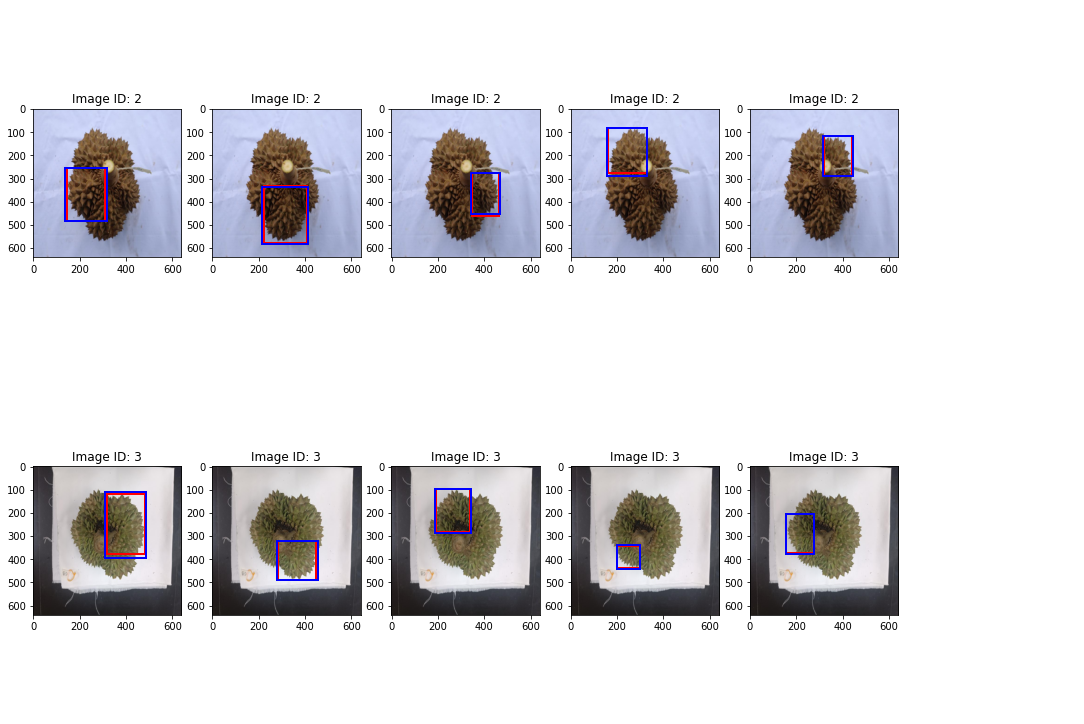

In [27]:
from mrcnn import utils
from mrcnn.utils import get_iou
import numpy as np
import matplotlib.pyplot as plt

def compute_performance_metrics(image_ids, iou_thresholds=[0.50, 0.75]):
    """
    Computes performance metrics (AP at IoU=0.50, AP at IoU=0.75, mean AP, and IoU)
    for the given image IDs.

    Args:
        image_ids: List of image IDs to evaluate.
        iou_thresholds: List of IoU thresholds for AP calculation (e.g., [0.50, 0.75]).

    Returns:
        A dictionary containing:
            - AP_50: List of APs for IoU=0.50
            - AP_75: List of APs for IoU=0.75
            - mAP: List of mean APs (average across thresholds)
            - IOUs: List of IoUs for each ground truth bounding box
            - image_data: Data needed for visualization, structured as:
                          {image_id: [(image, gt_box, best_pred_box), ...]}
    """
    AP_50 = []
    AP_75 = []
    mAPs = []
    IOUs = []
    image_data = {}

    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, test_config, image_id)
        
        # Run object detection
        results = test_model.detect([image], verbose=0)
        r = results[0]
        
        # Compute AP for IoU thresholds 0.50 and 0.75
        AP_50.append(utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.50)[0])
        AP_75.append(utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.75)[0])
        
        # Compute mean AP across thresholds (using utils.compute_ap_range if available)
        mAPs.append(utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], verbose=0))
        
        # Prepare bounding boxes for IoU computation and visualization
        bounding_boxes = []
        for gt_box in gt_bbox:
            best_iou = -1
            best_pred_box = None
            for pred_box in r['rois']:
                iou = get_iou([gt_box[1], gt_box[0], gt_box[3], gt_box[2]], [pred_box[1], pred_box[0], pred_box[3], pred_box[2]])
                if iou > best_iou:
                    best_iou = iou
                    best_pred_box = pred_box
            IOUs.append(best_iou)
            bounding_boxes.append((image, gt_box, best_pred_box))
        
        # Store bounding boxes for visualization
        image_data[image_id] = bounding_boxes
    

    # Collect results in a dictionary
    metrics = {
        "AP_50": np.mean(AP_50),
        "AP_75": np.mean(AP_75),
        "mAP": np.mean(mAPs),
        "IOUs": np.mean(IOUs),
        "image_data": image_data
    }
    return metrics

def display_bounding_boxes(image_data):
    """
    Display images with their ground truth and predicted bounding boxes in a grid layout.

    Args:
        image_data: A dictionary where keys are image IDs and values are lists of tuples 
                    containing (image, gt_box, best_pred_box).
    """
    selected_image_ids = random.sample(list(image_data.keys()), 3)
    selected_images = {image_id: image_data[image_id] for image_id in selected_image_ids}

    image_data = selected_images
    max_columns = 6  # Maximum number of columns
    rows = len(image_data)  # Number of unique image IDs
    grid_size = (rows, max_columns)  # Grid size (rows, columns)
    
    fig, axes = plt.subplots(*grid_size, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten the grid for easy iteration

    for idx, (image_id, bounding_boxes) in enumerate(image_data.items()):
        for col in range(max_columns):
            ax = axes[idx * max_columns + col]
            if col < len(bounding_boxes):
                image, gt_box, best_pred_box = bounding_boxes[col]
                draw_bounding_boxes(ax, image, gt_box, best_pred_box, image_id)
            else:
                ax.axis('off')  # Hide axes if no image available

    plt.tight_layout(pad=0.5, h_pad=0.5)  # Adjust layout
    plt.show()


def draw_bounding_boxes(ax, image, gt_box, best_pred_box, image_id):
    """
    Draw ground truth and predicted bounding boxes on the given axes.
    
    Args:
        ax: The axes to draw on.
        image: The image to display.
        gt_box: The ground truth bounding box in the format [y0, x1, y2, x2].
        best_pred_box: The best predicted bounding box in the format [y0, x1, y2, x2].
        image_id: The ID of the image.
    """
    ax.imshow(image)
    
    # Draw ground truth box
    gt_y0, gt_x1, gt_y2, gt_x2 = gt_box
    ax.add_patch(plt.Rectangle((gt_x1, gt_y0), gt_x2 - gt_x1, gt_y2 - gt_y0,
                                fill=False, edgecolor='red', lw=2, label='Ground Truth'))
    
    # Draw predicted box if it exists
    if best_pred_box is not None:
        pred_y0, pred_x1, pred_y2, pred_x2 = best_pred_box
        ax.add_patch(plt.Rectangle((pred_x1, pred_y0), pred_x2 - pred_x1, pred_y2 - pred_y0,
                                    fill=False, edgecolor='blue', lw=2, label='Prediction'))

    ax.set_title(f"Image ID: {image_id}")

# Usage
image_ids = dataset_test.image_ids
metrics = compute_performance_metrics(image_ids)

print("mAP @ IoU=50:", metrics["AP_50"])
print("mAP @ IoU=75:", metrics["AP_75"])
print("Mean mAP:", metrics["mAP"])
print("Mean IoU:", metrics["IOUs"])

# Display bounding boxes
display_bounding_boxes(metrics["image_data"])
